<img src="1.jpg">

In [1]:
import pandas as pd
import seaborn as sns

import warnings
warnings.simplefilter('ignore')


train = pd.read_csv('data/train_2kmZucJ.csv')
train.shape

(7920, 3)

In [2]:
train.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


In [3]:
# # extract only 0 feature
# train[train['label']==0].head()

<AxesSubplot:xlabel='label', ylabel='count'>

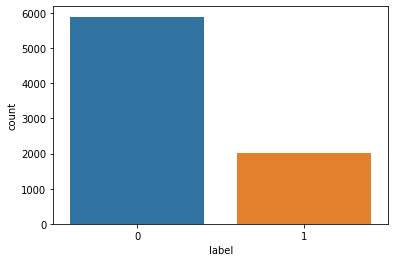

In [4]:
sns.countplot(train['label'])

In [5]:
train.label.value_counts(1)*100

0    74.419192
1    25.580808
Name: label, dtype: float64

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7920 entries, 0 to 7919
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7920 non-null   int64 
 1   label   7920 non-null   int64 
 2   tweet   7920 non-null   object
dtypes: int64(2), object(1)
memory usage: 185.8+ KB


In [7]:
train = train.drop('id',axis=1)

## Preprocess tweet data

In [8]:
import re
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.corpus import stopwords
# ps = PorterStemmer()
wo = WordNetLemmatizer()
corpus=[]
for i in range(0,len(train)):
    message = re.sub('[^a-zA-Z]',' ',train['tweet'][i])
    message = message.lower()
    message = message.split()
    message = [wo.lemmatize(word) for word in message if word not in set(stopwords.words('english'))]
    message = ' '.join(message)
    corpus.append(message)

In [9]:
len(corpus)

7920

## Split Data

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(corpus,train['label'],test_size=0.25,random_state=42)

### Use TFIDF

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [12]:
X_train_vect.shape

(5940, 17626)

## Fix Imbalance

In [13]:
from imblearn.over_sampling import SMOTE
x_resample, y_resample = SMOTE().fit_sample(X_train_vect, y_train)
# lets print the shape of x and y after resampling it
print(x_resample.shape)
print(y_resample.shape)

(8910, 17626)
(8910,)


In [14]:
x_test_resample, y_test_resample = SMOTE().fit_sample(X_test_vect, y_test)

## Model

In [15]:
from sklearn.metrics import classification_report,f1_score

## Logistic

In [16]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver='lbfgs')
clf.fit(x_resample, y_resample)

LogisticRegression()

In [17]:
y_pred = clf.predict(x_test_resample)
print("f1 score is: ",f1_score(y_test_resample,y_pred))
cr = classification_report(y_test_resample, y_pred)
print(cr)

f1 score is:  0.8911516853932584
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1439
           1       0.90      0.88      0.89      1439

    accuracy                           0.89      2878
   macro avg       0.89      0.89      0.89      2878
weighted avg       0.89      0.89      0.89      2878



### LGB

In [27]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier().fit(x_resample, y_resample)

In [28]:
y_pred = lgb.predict(x_test_resample)
print("f1 score is: ",f1_score(y_test_resample,y_pred))
cr = classification_report(y_test_resample, y_pred)
print(cr)

f1 score is:  0.8924806746310611
              precision    recall  f1-score   support

           0       0.89      0.90      0.89      1439
           1       0.90      0.88      0.89      1439

    accuracy                           0.89      2878
   macro avg       0.89      0.89      0.89      2878
weighted avg       0.89      0.89      0.89      2878



## Test Section

In [29]:
test = pd.read_csv('data/test_oJQbWVk.csv')
print(test.shape)
test.head()

(1953, 2)


,id,tweet
0,7921,I hate the new #iphone upgrade. Won't let me d...
1,7922,currently shitting my fucking pants. #apple #i...
2,7923,"I'd like to puts some CD-ROMS on my iPad, is t..."
3,7924,My ipod is officially dead. I lost all my pict...
4,7925,Been fighting iTunes all night! I only want th...


## TExt tweet preprocess

In [30]:
import re
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.corpus import stopwords
# ps = PorterStemmer()
wo = WordNetLemmatizer()
corpus_test=[]
for i in range(0,len(test)):
    mes = re.sub('[^a-zA-Z]',' ',test['tweet'][i])
    mes = mes.lower()
    mes = mes.split()
    mes = [wo.lemmatize(word) for word in mes if word not in set(stopwords.words('english'))]
    mes = ' '.join(mes)
    corpus_test.append(mes)

### Apply tfidf

In [31]:
testing_data = vectorizer.transform(corpus_test)
testing_data.shape

(1953, 17626)

In [32]:
preds_test = lgb.predict(testing_data)

## SUbmission File

In [33]:
sub = pd.read_csv('data/sample_submission_LnhVWA4.csv')
sub['label'] = preds_test

In [34]:
sub.head()

,id,label
0,7921,1
1,7922,1
2,7923,1
3,7924,1
4,7925,1


In [35]:
sub.label.value_counts(1)*100

0    71.377368
1    28.622632
Name: label, dtype: float64

In [36]:
sub.to_csv('model5.csv',index=False)